In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from autode.geom import calc_rmsd
from autode.input_output import xyz_file_to_atoms

In [2]:
def rmsd_from_xyz_file_names(filename1, filename2):
    atoms1 = xyz_file_to_atoms(filename1)
    atoms2 = xyz_file_to_atoms(filename2)
    return calc_rmsd(atoms1.coordinates, atoms2.coordinates)

In [3]:
def get_dhs_gs_rmsd_and_total_iters(idx):
    dirname = f"dhs_gs/reaction-{idx}/"
    file_list = list(glob.glob(dirname+f"reaction-{idx}-dhs-gs.sh.e*"))
    if len(file_list) == 0:
        return None, None
        
    assert len(file_list) == 1
    outfile = file_list[0]
    with open(outfile, encoding='utf-8') as fh:
        end_line = None
        for line in fh:
            if "Finished DHSGS procedure in" in line:
                end_line = line
                break
    
    if end_line is None:
        return None, None
    macro, micro = end_line.split()[6], end_line.split()[10]
    macro, micro = int(macro), int(micro)
    
    iters = macro + micro + 2
    
    xyzfile = dirname + "dhsgs/DHSGS_ts_guess.xyz"
    ts_out_file = dirname + f"ts-opt/reaction-{idx}-dhsgs_optts.out"
    ts_ref_file = dirname + f"ts-opt/reaction-{idx}-dhsgs_optts_Compound_1.xyz"
    if not os.path.isfile(ts_ref_file) or not os.path.isfile(xyzfile):
        return None, None
    rmsd = rmsd_from_xyz_file_names(xyzfile, ts_ref_file)
    return round(rmsd, 3), int(iters)

In [4]:
def get_cineb_rmsd_and_total_iters(idx, image_num):
    dirname = f"ci_neb_{image_num}/reaction-{idx}/"
    
    # number of gradient evals
    orca_out_files = list(glob.glob(dirname+f"neb/*/*_orca.out"))
    iters = len(orca_out_files)
    
    # Check if optimisation successful
    if not os.path.isfile(dirname+"/neb/neb_optimised.xyz"):
        return None, None
    
    ts_ref_file = dirname + f"ts-opt/reaction-{idx}-cineb{image_num}_optts_Compound_1.xyz"
    xyzfile = dirname + f"cineb-{image_num}-peak.xyz"
    if not os.path.isfile(ts_ref_file) or not os.path.isfile(xyzfile):
        return None, None
    rmsd = rmsd_from_xyz_file_names(xyzfile, ts_ref_file)
    
    return round(rmsd, 3), int(iters)

In [5]:
"""
def get_orca_cineb_rmsd_and_total_iters(idx):
    dirname = f"orca_neb_ref/reaction-{idx}/"
    
    # number of gradient evals
    outfile = dirname + f"reaction-{idx}-pbeh3c-orca_neb.out"
    if not os.path.isfile(outfile):
        return (None, None)
    check_line = None
    with open(outfile, encoding='utf-8') as fh:
        for line in fh:
            if "The elastic band and climbing image have converged successfully" in line:
                check_line = line
                break
    if check_line is None:
        return (None, None)

    lbfgs_iters = check_line.strip().split()[-2]
    iters = int(20 * int(lbfgs_iters) + 2)
    
    # rmsd
    ts_ref_file = f"orca_ts_opt_from_neb_ref/reaction-{idx}/reaction-{idx}-pbeh3c-orca_optts.xyz"
    xyzfile = dirname + f"reaction-{idx}-pbeh3c-orca_neb_NEB-CI_converged.xyz"
    if not os.path.isfile(ts_ref_file) or not os.path.isfile(xyzfile):
        return None, None
    rmsd = rmsd_from_xyz_file_names(xyzfile, ts_ref_file)
    
    return round(rmsd, 3), int(iters)
"""
None

In [6]:
def get_ieip_rmsd_and_total_iters(idx):
    dirname = f"i_eip/reaction-{idx}/"
    file_list = list(glob.glob(dirname+f"reaction-{idx}-i-eip.sh.e*"))
    if len(file_list) == 0:
        return None, None
    assert len(file_list) == 1
    outfile = file_list[0]
    with open(outfile, encoding='utf-8') as fh:
        end_line = None
        for line in fh:
            if "Finished IEIP procedure in" in line:
                end_line = line
                break
    if end_line is None:
        return None, None
    # for ieip macro-iter + 2 (initialise) + 2 (redistribution)
    macro = end_line.split()[6]
    iters = int(macro) + 4
    
    ts_ref_file = dirname + f"ts-opt/reaction-{idx}-ieip_optts_Compound_1.xyz"
    xyzfile = dirname + f"ieip/IEIP_ts_guess.xyz"
    if not os.path.isfile(ts_ref_file) or not os.path.isfile(xyzfile):
        return None, None
    rmsd = rmsd_from_xyz_file_names(xyzfile, ts_ref_file)
    return round(rmsd, 3), int(iters)

In [7]:
row_names = [f"R{idx}" for idx in range(0, 8)]
col_names_base = ["CINEB(5)", "CINEB(10)", "DHS-GS", "i-EIP"]

df_rmsd = pd.DataFrame(np.zeros(shape=(8, 4)), index = row_names, columns = col_names_base)

df_iters = pd.DataFrame(np.zeros(shape=(8, 4)), index = row_names, columns = col_names_base)

df_failures = pd.DataFrame(np.full((8, 4),"Success" ,dtype=object), index = row_names, columns = col_names_base)

In [8]:
for i in range(0, 8):
    
    cineb5_rmsd, cineb5_iters = get_cineb_rmsd_and_total_iters(i, 5)
    df_rmsd.loc[f"R{i}", "CINEB(5)"] = cineb5_rmsd
    df_iters.loc[f"R{i}", "CINEB(5)"] = cineb5_iters
    if cineb5_rmsd is None:
        df_failures.loc[f"R{i}","CINEB(5)"] = "Method failed"
    
    cineb10_rmsd, cineb10_iters = get_cineb_rmsd_and_total_iters(i, 10)
    df_rmsd.loc[f"R{i}", "CINEB(10)"] = cineb10_rmsd
    df_iters.loc[f"R{i}", "CINEB(10)"] = cineb10_iters
    if cineb10_rmsd is None:
        df_failures.loc[f"R{i}","CINEB(10)"] = "Method failed"
    
    dhsgs_rmsd, dhsgs_iters = get_dhs_gs_rmsd_and_total_iters(i)
    df_rmsd.loc[f"R{i}", "DHS-GS"] = dhsgs_rmsd
    df_iters.loc[f"R{i}", "DHS-GS"] = dhsgs_iters
    if dhsgs_rmsd is None:
        df_failures.loc[f"R{i}", "DHS-GS"] = "Method failed"
    
    ieip_rmsd, ieip_iters = get_ieip_rmsd_and_total_iters(i)
    df_rmsd.loc[f"R{i}", "i-EIP"] = ieip_rmsd
    df_iters.loc[f"R{i}", "i-EIP"] = ieip_iters
    if ieip_rmsd is None:
        df_failures.loc[f"R{i}", "i-EIP"] = "Method failed"
    

In [9]:
# Manually check failures and put them into the dataset
failures = [
    [("R3", "CINEB(5)"),  "Incorrect TS"],
    [("R4", "CINEB(5)"), "TS opt failed"], # TS-opt did not converge
    [("R0", "CINEB(10)"), "Incorrect TS"], # converged to wrong TS
    [("R1", "CINEB(10)"), "Incorrect TS"], # converged to wrong TS
    [("R2", "CINEB(10)"), "TS opt failed"], # TS-opt did not converge
    [("R3", "CINEB(10)"), "Incorrect TS"], # converged to wrong TS
    [("R4", "CINEB(10)"), "Incorrect TS"], # converged to wrong TS
    [("R4", "DHS-GS"), "Incorrect TS"],  # converged to wrong TS
    [("R4", "i-EIP"), "Incorrect TS"], # converged to wrong TS
]

# TODO: R4 - CINEB10

for data in failures:
    df_rmsd.loc[data[0][0], data[0][1]] = None
    df_iters.loc[data[0][0], data[0][1]] = None
    df_failures.loc[data[0][0], data[0][1]] = data[1]

In [27]:
df_rmsd.mean()

CINEB(5)     0.350250
CINEB(10)    0.290667
DHS-GS       0.330250
i-EIP        0.403286
dtype: float64

In [13]:
df_iters.mean().mean()

140.2797619047619

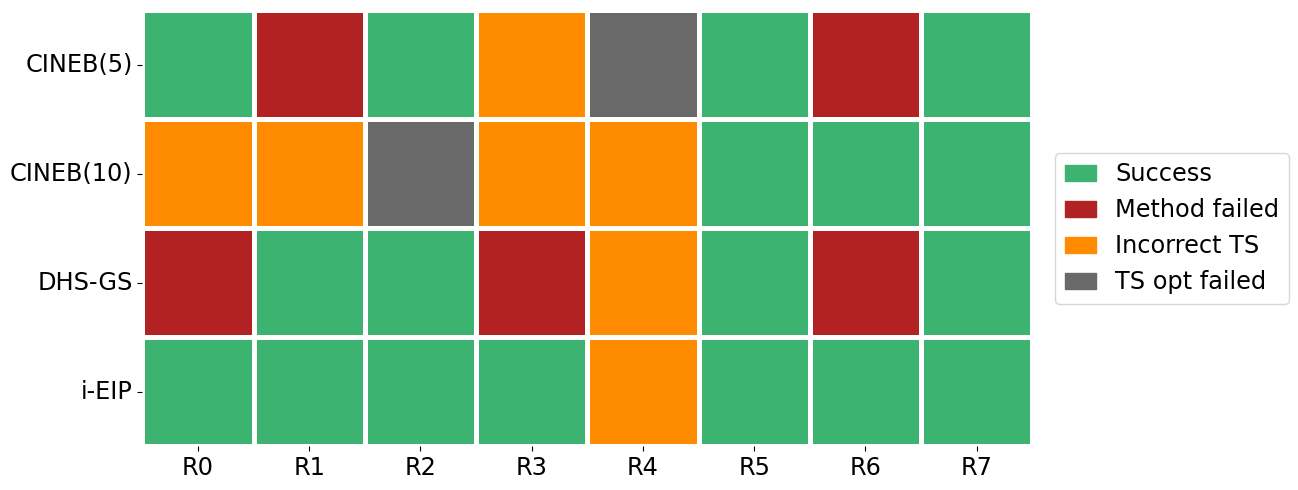

In [14]:
# Graphing
categorical_to_int = {'Success':0, 'Method failed':1,'Incorrect TS':2 ,'TS opt failed':3}
tab10 = plt.get_cmap('tab10')
cmap = ListedColormap(["mediumseagreen", "firebrick", "darkorange", "dimgrey"])
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(df_failures.transpose().replace(categorical_to_int), cmap=cmap,ax=ax, cbar=False, linewidths=3.5, linecolor='w')
# reduce the size of heatmap a little
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
# reconstruct color map
colors = cmap(np.linspace(0, 1, len(categorical_to_int)))
# add color map to legend
patches = [mpatches.Patch(facecolor=c, edgecolor=c) for c in colors]
legend = ax.legend(patches,
    sorted(categorical_to_int.keys(), key=categorical_to_int.get),
    handlelength=1.3, fontsize="xx-large",
    bbox_to_anchor = (1.2, -0.3, 0.102, 1.), ncol=1)
for t in legend.get_texts():
    t.set_ha("left")
ax.tick_params(which='major',labelsize='xx-large')
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout()
plt.savefig("TS-search-results-summary.pdf", dpi=600, bbox_inches="tight")

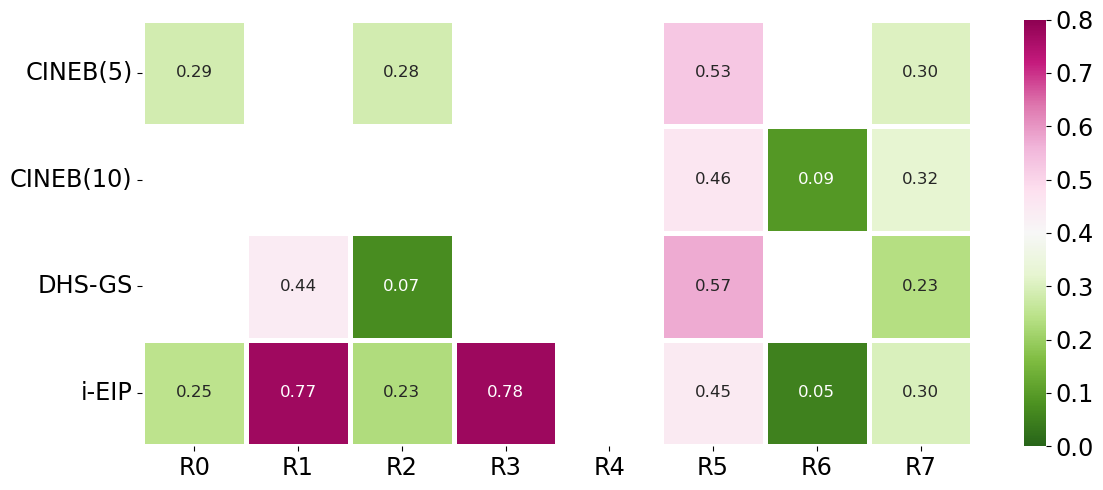

In [26]:
# Graphing
myfigsize=(12,5)
fig,ax = plt.subplots(figsize=myfigsize)
sns.heatmap(df_rmsd.transpose(),cmap='PiYG_r',ax=ax,annot=True,fmt='.2f',linewidths=3.5,linecolor='w',annot_kws={'fontsize':'large'},vmin=0.00,vmax=0.8)
#ax.tick_params(which='major',left=False,bottom=False)
ax.tick_params(which='major',labelsize='xx-large')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize='xx-large')
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout()
plt.savefig("TS-search-rmsd-heatmap.pdf", dpi=600, bbox_inches="tight")

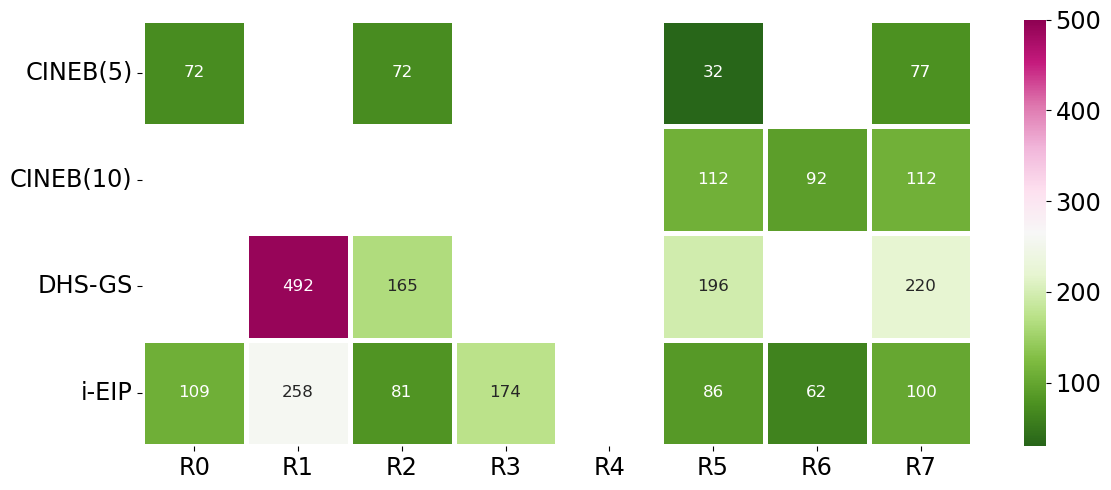

In [25]:
# Graphing
myfigsize=(12,5)
fig,ax = plt.subplots(figsize=myfigsize)
sns.heatmap(df_iters.transpose(),cmap='PiYG_r',ax=ax,annot=True,fmt='.0f',linewidths=3.5,linecolor='w',annot_kws={'fontsize':'large'},vmin=30,vmax=500)
#ax.tick_params(which='major',left=False,bottom=False)
ax.tick_params(which='major',labelsize='xx-large')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize='xx-large')
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout()
plt.savefig("TS-search-iterations-heatmap.pdf", dpi=600, bbox_inches="tight")

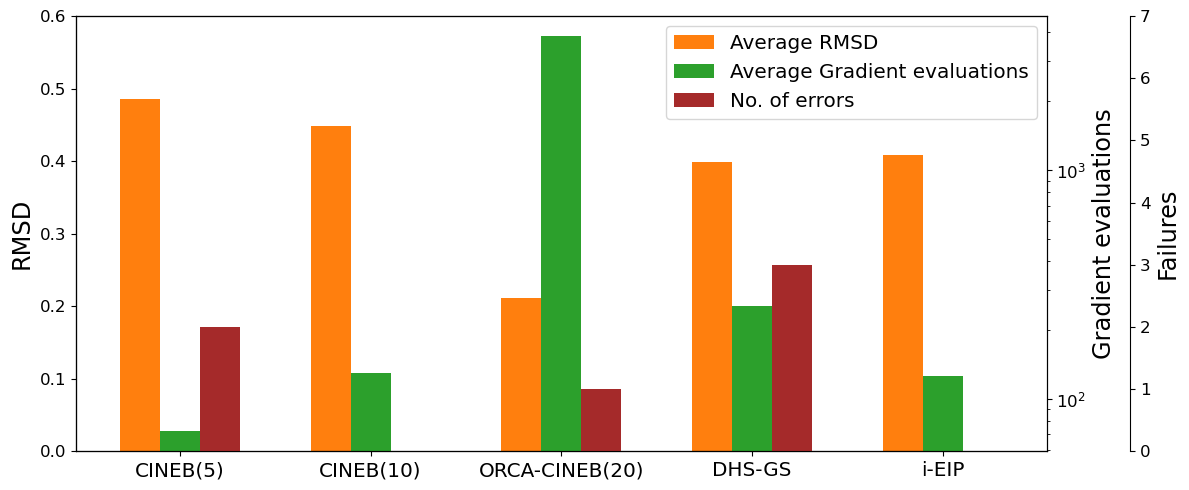

In [14]:
# summary plot
avg_rmsds = list(df_rmsd.mean())
avg_iters = list(df_iters.mean())
failures = list(df_failures.iloc[0])
labels = list(df_rmsd.columns)

fig, ax = plt.subplots(figsize=(12,4.5)) # 12,4.5 for report plot, 12, 5 for poster
ax2 = ax.twinx()
ax3 = ax.twinx()

x = np.arange(len(labels))
width = 0.21
rect1 = ax.bar(x - width, avg_rmsds, width, label="Average RMSD", color="C1")
rect2 = ax2.bar(x, avg_iters, width, label="Average Gradient evaluations", color="C2")
rect3 = ax3.bar(x + width, failures, width, label="No. of errors", color="brown")
fig.legend(fontsize='x-large',bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

ax.set_ylabel("RMSD", fontsize='xx-large')
ax.set_ylim(0, 0.6)
ax.set_xticks(x, labels, fontsize="x-large")
ax.tick_params(axis='y', labelsize='large')

ax2.set_ylabel("Gradient evaluations", fontsize='xx-large')
ax2.set_yscale('log') # log scale to avoid ORCA swamping everything else
ax2.tick_params(axis='y', labelsize='large')

ax3.set_ylabel("Failures", fontsize='xx-large')
ax3.tick_params(axis='y', labelsize='large')
ax3.set_ylim(0, 7)
ax3.spines["right"].set_position(('outward', 60))

plt.tight_layout()
plt.savefig("TS-search-bench-summary.pdf", dpi=600, bbox_inches="tight")